In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
from tqdm import tqdm


In [2]:

def get_files_in_subdirectories(parent_dir):
    files_dict = {}
    
    # Loop through each item in the parent directory
    for subdir_name in os.listdir(parent_dir):
        subdir_path = os.path.join(parent_dir, subdir_name)
        
        # Check if the item is a directory
        if os.path.isdir(subdir_path):
            # Get all file names in this subdirectory
            files = [file for file in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, file))]
            files_dict[subdir_name] = files  # Map the subdirectory name to its list of files
    
    return files_dict

# Example usage
parent_directory = 'data\kth_dataset\\'
files_in_subdirs = get_files_in_subdirectories(parent_directory)
print(files_in_subdirs)


{'boxing': ['person01_boxing_d1_uncomp.avi', 'person01_boxing_d2_uncomp.avi', 'person01_boxing_d3_uncomp.avi', 'person01_boxing_d4_uncomp.avi', 'person02_boxing_d1_uncomp.avi', 'person02_boxing_d2_uncomp.avi', 'person02_boxing_d3_uncomp.avi', 'person02_boxing_d4_uncomp.avi', 'person03_boxing_d1_uncomp.avi', 'person03_boxing_d2_uncomp.avi', 'person03_boxing_d3_uncomp.avi', 'person03_boxing_d4_uncomp.avi', 'person04_boxing_d1_uncomp.avi', 'person04_boxing_d2_uncomp.avi', 'person04_boxing_d3_uncomp.avi', 'person04_boxing_d4_uncomp.avi', 'person05_boxing_d1_uncomp.avi', 'person05_boxing_d2_uncomp.avi', 'person05_boxing_d3_uncomp.avi', 'person05_boxing_d4_uncomp.avi', 'person06_boxing_d1_uncomp.avi', 'person06_boxing_d2_uncomp.avi', 'person06_boxing_d3_uncomp.avi', 'person06_boxing_d4_uncomp.avi', 'person07_boxing_d1_uncomp.avi', 'person07_boxing_d2_uncomp.avi', 'person07_boxing_d3_uncomp.avi', 'person07_boxing_d4_uncomp.avi', 'person08_boxing_d1_uncomp.avi', 'person08_boxing_d2_uncomp.avi'

In [3]:
def parse_frame_ranges(frame_ranges):
    # print(frame_ranges)
    frame_indices = []
    for range_str in frame_ranges:
        # Strip any trailing commas and whitespace from each range string
        range_str = range_str.strip(', ')
        
        # Split each range on '-'
        start_end = range_str.split('-')
        
        # If we have a valid range, expand it
        if len(start_end) == 2:
            start, end = int(start_end[0]), int(start_end[1])
            frame_indices.extend(range(start-1, end))
        elif len(start_end) == 1:
            # Single frame case (if only one frame number is given)
            frame_indices.append(int(start_end[0]-1))

    return frame_indices
def load_frame_numbers(file_path):
    frame_numbers = {}
    with open(file_path, 'r') as f:
        for line in f:
            if len(line)<=1:
                continue

            frame_numbers[line.split()[0]] = parse_frame_ranges(line.split()[2:])
    return frame_numbers

frames_dict = load_frame_numbers(parent_directory+"00sequences.txt")

In [4]:
# def process_video_mog(path):

#     cap = cv2.VideoCapture(path)

#     # Create a background subtractor
#     # background_subtractor = cv2.createBackgroundSubtractorMOG2(history=200, varThreshold=40, detectShadows=False)
#     background_subtractor = cv2.createBackgroundSubtractorKNN(history=150, dist2Threshold=70, detectShadows=False)

#     # Initialize a list to store the processed frames
#     processed_frames = []

#     # Loop over frames
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break
        
#         downsampling_scale = 1.0
#         height, width = frame.shape[:2]        
#         # frame_resized = cv2.resize(frame, (70, 30))

#         frame_resized = cv2.resize(frame, (int(width * downsampling_scale), int(height * downsampling_scale)))

        
#         # Apply background subtraction to get the foreground mask
#         mask = background_subtractor.apply(frame_resized)

#         # Create a binary mask: white where the person is, black elsewhere
#         _, mask = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)
        
#         # Invert the mask so the person is black, background is white
#         # mask = cv2.bitwise_not(mask)
        
#         # Append the processed mask (as a NumPy array) to the list
#         processed_frames.append(mask)

#     # Release video object
#     cap.release()

#     # Convert list of frames to a 3D numpy array
#     # Shape: (number_of_frames, height, width)
#     processed_frames_array = np.array(processed_frames)

#     # print("Processing complete. The frames are stored as a numpy array")
#     # print("Array shape:", processed_frames_array.shape)
#     return processed_frames_array

In [5]:


def process_video(path, output_size=(40, 30)):
    # Initialize MediaPipe Selfie Segmentation
    filename = path.split('/')[-1]
    trimmed_filename = "_".join(filename.split('_')[:-1])
    # print(frames_dict[trimmed_filename])
    mp_selfie_segmentation = mp.solutions.selfie_segmentation
    segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

    cap = cv2.VideoCapture(path)
    processed_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB for MediaPipe processing
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Apply segmentation model
        results = segmentation.process(frame_rgb)

        mask = (results.segmentation_mask * 255).astype(np.uint8)

        # Apply Otsu’s thresholding
        _, otsu_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        resized_mask = cv2.resize(otsu_mask, output_size, interpolation=cv2.INTER_NEAREST)

        # Normalize the resized mask back to 0 and 1
        resized_mask = (resized_mask > 0).astype(np.uint8)


        

        # # Extract mask for the person
        # mask = (results.segmentation_mask > 0.5).astype(np.uint8)

        # Resize the mask to the desired output size
        # resized_mask = cv2.resize(mask, output_size, interpolation=cv2.INTER_NEAREST)
        # resized_mask = mask
        # Invert the mask so the person is black, background is white
        # resized_mask = cv2.bitwise_not(resized_mask)

        # Append the processed mask to the list
        processed_frames.append(resized_mask)

    cap.release()

    processed_frames_array = np.array(processed_frames)
    # print("Processing complete. The frames are stored as a numpy array")
    # print("Array shape:", processed_frames_array.shape)
    # return processed_frames_array
    # print(processed_frames_array.shape, processed_frames_array[frames_dict[trimmed_filename]].shape)
    return processed_frames_array[frames_dict[trimmed_filename]]


video name = person09_running_d1_uncomp.avi


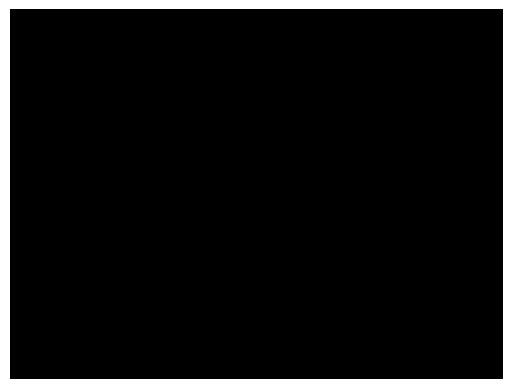

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Assuming processed_frames_array is a 3D numpy array (num_frames, height, width)
dir_idx, idx = 4, 32
processed_frames_array = process_video(f"{parent_directory}{list(files_in_subdirs.keys())[dir_idx]}/{files_in_subdirs[list(files_in_subdirs.keys())[dir_idx]][idx]}", (80, 60))
print(f"video name = {files_in_subdirs[list(files_in_subdirs.keys())[dir_idx]][idx]}")

# Set up the figure and axis
fig, ax = plt.subplots()
ax.axis('off')  # Hide axes for cleaner video display

# Display the first frame
im = ax.imshow(processed_frames_array[0], cmap='gray', vmin=0, vmax=255)

# Update function for animation
def update(frame):
    im.set_array(processed_frames_array[frame]*255)
    return [im]

# Create the animation
num_frames = processed_frames_array.shape[0]
ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=40)

# Display the animation in Jupyter Notebook
HTML(ani.to_jshtml())


In [7]:
np.unique(processed_frames_array)

array([0, 1], dtype=uint8)

In [8]:
classwise_groups = {
    key:[] for key in list(files_in_subdirs.keys())
}

for class_name, video_names in files_in_subdirs.items():
    
    for video_name in tqdm(video_names):
        # print(video_name)
        processed_array = processed_frames_array = process_video(f"{parent_directory}{class_name}/{video_name}", output_size=(40, 30))

        group_size = 4
        stride = 3
        # Calculate padding needed to make the frame count a multiple of the stride
        padding_needed = (stride - (processed_array.shape[0] - group_size) % stride) % stride
        if padding_needed > 0:
            padding = np.zeros((padding_needed, 30, 40))
            frames = np.concatenate((processed_array, padding), axis=0)
        else:
            frames = np.array(processed_array)
        # Calculate the number of groups
        num_groups = (frames.shape[0] - group_size) // stride + 1


        
        # Use stride tricks to create overlapping groups
        shape = (num_groups, group_size, 30, 40)
        strides = (frames.strides[0] * stride, *frames.strides)
        grouped_frames = np.lib.stride_tricks.as_strided(frames, shape=shape, strides=strides)

        grouped_frames = ((
            grouped_frames[:, 0, :, :]*1000+
            grouped_frames[:, 1, :, :]*100+
            grouped_frames[:, 2, :, :]*10+
            grouped_frames[:, 3, :, :]
        ))


        # print(f"processed array shape = {processed_array.shape}, grouped array shape = {grouped_frames.shape}")
        
                
        classwise_groups[class_name].append(grouped_frames)

        



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:33<00:00,  2.13s/it]


In [9]:
classwise_groups = {key:np.concatenate(value, axis=0) for key, value in classwise_groups.items()}

In [10]:
np.unique(classwise_groups['walking'])

array([0.000e+00, 1.000e+00, 1.000e+01, 1.100e+01, 1.000e+02, 1.010e+02,
       1.100e+02, 1.110e+02, 1.000e+03, 1.001e+03, 1.010e+03, 1.011e+03,
       1.100e+03, 1.101e+03, 1.110e+03, 1.111e+03])

In [11]:

np.savez("data/kth_dataset/processed_data.npz", **classwise_groups)

In [12]:
for key, value in classwise_groups.items():
    print(value.shape)

(14548, 30, 40)
(14030, 30, 40)
(17112, 30, 40)
(9061, 30, 40)
(6522, 30, 40)
(14581, 30, 40)


In [13]:

# # Define group size and overlap
# group_size = 4
# stride = group_size - 1

# # Calculate padding needed to make the frame count a multiple of the stride
# padding_needed = (stride - (processed_frames_array.shape[0] - group_size) % stride) % stride
# if padding_needed > 0:
#     padding = np.zeros((padding_needed, 60, 80))
#     frames = np.concatenate((processed_frames_array, padding), axis=0)
# else:
#     frames = np.array(processed_frames_array)

# # Calculate the number of groups
# num_groups = (frames.shape[0] - group_size) // stride + 1

# # Use stride tricks to create overlapping groups
# shape = (num_groups, group_size, 60, 80)
# strides = (frames.strides[0] * stride, *frames.strides)
# grouped_frames = np.lib.stride_tricks.as_strided(frames, shape=shape, strides=strides)

# # Check the shape of the result
# print(grouped_frames.shape)

In [14]:
# processed_frames_array.shape

In [15]:
# ((
#     grouped_frames[:, 0, :, :]*1000+
#     grouped_frames[:, 1, :, :]*100+
#     grouped_frames[:, 2, :, :]*10+
#     grouped_frames[:, 3, :, :]
# )/255).shape